In [144]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score , precision_score, recall_score
import seaborn as sns
from sklearn.metrics import f1_score
from localcider.sequenceParameters import SequenceParameters
import AD_predictor_tools

# Human AD Predictor
- Plan:
    - For each tile, count AAs + CIDER features
    - Class imbalance function
    - 60% training / 40% test
    - Random forest
- Other ideas:
    - Could train on only TFs with annotated ADs, assuming only these have complete set of annotations

# 0. Preparing training data
- Tiling lambert at 40AAs with no overlap
- Calculate features
    - Counts of 20AAs
    - CIDER:
        - frac pos, frac neg, frac disor promoting, ncpr    
- Using smote to address class imbalance 
- Split data to 60% training, 40% testing
- Annotate as AD if >= 80% of a tile overlaps an entry of known ADs list

In [348]:
# Tiling lambert 
classifier_input = AD_predictor_tools.makeTilingDF("../output/lambert_TFs_10-21-24_with_DBD_coords.fasta", window_size = 40, window_spacing = 40)
classifier_input = classifier_input.iloc[:, :4]
classifier_input

Using existing Tiling DF at ../data/TilingDFs/lambert_TFs_10-21-24_with_DBD_coords_size_40_space_40_AAs_W,F,Y,M,L,Q.csv


,ProteinWindowSeq,GeneName,StartPosition,EndPosition
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200
...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640


In [349]:
# AA counts
AAs = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

for AA in AAs:
    classifier_input[AA] = classifier_input["ProteinWindowSeq"].str.count(AA)

classifier_input

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,2,0,3,5,1,4,...,2,2,3,1,1,3,2,2,0,0
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,2,0,3,2,0,2,...,1,2,5,3,3,2,2,3,1,0
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,2,0,1,12,0,0,...,0,0,2,2,1,5,2,1,1,0
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,2,1,1,8,1,1,...,0,1,1,3,1,7,1,3,0,0
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,2,4,2,1,...,0,2,0,5,6,6,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,5,0,2,7,3,0,...,0,2,2,1,0,6,2,1,1,0
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,6,1,0,4,1,1,...,0,0,1,5,7,0,1,3,0,3
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,5,0,0,1,2,0,...,1,0,0,6,3,3,1,1,0,5
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,4,1,1,0,0,1,...,0,0,0,6,6,3,2,2,0,3


In [350]:
# CIDER features
classifier_input["frac_neg"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_fraction_negative())
classifier_input["frac_pos"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_fraction_positive())
classifier_input["frac_disord_prom"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_fraction_disorder_promoting())
classifier_input["ncpr"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_NCPR(pH = None))
classifier_input

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,A,C,D,E,F,G,...,R,S,T,V,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,2,0,3,5,1,4,...,1,3,2,2,0,0,0.200000,0.050000,0.65000,-0.150000
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,2,0,3,2,0,2,...,3,2,2,3,1,0,0.125000,0.100000,0.62500,-0.025000
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,2,0,1,12,0,0,...,1,5,2,1,1,0,0.325000,0.125000,0.82500,-0.200000
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,2,1,1,8,1,1,...,1,7,1,3,0,0,0.225000,0.075000,0.72500,-0.150000
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,2,4,2,1,...,6,6,1,1,0,1,0.150000,0.200000,0.72500,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,5,0,2,7,3,0,...,0,6,2,1,1,0,0.225000,0.050000,0.70000,-0.175000
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,6,1,0,4,1,1,...,7,0,1,3,0,3,0.100000,0.250000,0.70000,0.150000
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,5,0,0,1,2,0,...,3,3,1,1,0,5,0.025000,0.225000,0.62500,0.200000
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,4,1,1,0,0,1,...,6,3,2,2,0,3,0.025000,0.325000,0.75000,0.300000


In [351]:
all_known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms.csv")
# Only keep ADs on Lambert TFs
known_ADs = all_known_ADs[all_known_ADs["TileType"] == "TF"]
classifier_input["uniprotID"] = classifier_input["GeneName"].str.split("|").str[1]
known_ADs = known_ADs[known_ADs["uniprotID"].isin(classifier_input["uniprotID"])]
# Preparing known AD coords for merge
known_AD_coords = known_ADs[["uniprotID", "Start", "End"]]
known_AD_coords = known_AD_coords.rename(columns = {"Start" : "annot_Start", "End" : "annot_End"})
known_AD_coords

,uniprotID,annot_Start,annot_End
1,Q8IUX7,1088,1158
2,Q8WYP5,1445,1698
3,P35869,118,126
4,P35869,266,268
5,P35869,532,848
...,...,...,...
739,P17040,262,341
740,P98168,572,699
741,P98169,576,703
742,Q2QGD7,579,688


In [352]:
def add_overlap_status(df, domain_list, col_type, min_overlap = 32, col_name_suffix =  "_suffic_overlap"):
    # Keep rows of adhunter with annots
    # Calculate interval overlap
    # If there is overlap of at least 80% (so >= 32 residues) then there is sufficient overlap
    df_with_annots = pd.merge(df, domain_list, on = "uniprotID")
    df_with_annots["overlap_length"] =  df_with_annots[['End', 'annot_End']].min(axis=1) - df_with_annots[['Start', 'annot_Start']].max(axis=1)
    df_with_annots[col_type+ "_suffic_overlap"] = df_with_annots["overlap_length"] >= min_overlap
    #display(df_with_annots)
    
    # Keep first of each tile, such that if there is an overlappign tile it is saved
    df_with_annots = df_with_annots.sort_values(by = col_type+ "_suffic_overlap", ascending = False)
    df_with_annots = df_with_annots.drop_duplicates(subset = ["ProteinWindowSeq"], keep = "first")
    #display(df_with_annots)
    
    # Add info back to full tile table (includes TFs with no annotated ADs)
    #display(df)
    df = pd.merge(df, df_with_annots[["ProteinWindowSeq", col_type+ "_suffic_overlap"]], how = "left")
    df = df.fillna(False)
    return df

In [353]:
classifier_input = classifier_input.rename(columns = {"StartPosition" : "Start", "EndPosition" : "End"})
classifier_input

,ProteinWindowSeq,GeneName,Start,End,A,C,D,E,F,G,...,S,T,V,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr,uniprotID
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,2,0,3,5,1,4,...,3,2,2,0,0,0.200000,0.050000,0.65000,-0.150000,A0A087WUV0
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,2,0,3,2,0,2,...,2,2,3,1,0,0.125000,0.100000,0.62500,-0.025000,A0A087WUV0
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,2,0,1,12,0,0,...,5,2,1,1,0,0.325000,0.125000,0.82500,-0.200000,A0A087WUV0
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,2,1,1,8,1,1,...,7,1,3,0,0,0.225000,0.075000,0.72500,-0.150000,A0A087WUV0
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,2,4,2,1,...,6,1,1,0,1,0.150000,0.200000,0.72500,0.050000,A0A087WUV0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,5,0,2,7,3,0,...,6,2,1,1,0,0.225000,0.050000,0.70000,-0.175000,Q9Y6Y1
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,6,1,0,4,1,1,...,0,1,3,0,3,0.100000,0.250000,0.70000,0.150000,Q9Y6Y1
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,5,0,0,1,2,0,...,3,1,1,0,5,0.025000,0.225000,0.62500,0.200000,Q9Y6Y1
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,4,1,1,0,0,1,...,3,2,2,0,3,0.025000,0.325000,0.75000,0.300000,Q9Y6Y1


In [354]:
classifier_input = add_overlap_status(classifier_input, known_AD_coords, "AD")
classifier_input

,ProteinWindowSeq,GeneName,Start,End,A,C,D,E,F,G,...,T,V,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr,uniprotID,AD_suffic_overlap
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,2,0,3,5,1,4,...,2,2,0,0,0.200000,0.050000,0.65000,-0.150000,A0A087WUV0,False
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,2,0,3,2,0,2,...,2,3,1,0,0.125000,0.100000,0.62500,-0.025000,A0A087WUV0,False
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,2,0,1,12,0,0,...,2,1,1,0,0.325000,0.125000,0.82500,-0.200000,A0A087WUV0,False
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,2,1,1,8,1,1,...,1,3,0,0,0.225000,0.075000,0.72500,-0.150000,A0A087WUV0,False
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,2,4,2,1,...,1,1,0,1,0.150000,0.200000,0.72500,0.050000,A0A087WUV0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,5,0,2,7,3,0,...,2,1,1,0,0.225000,0.050000,0.70000,-0.175000,Q9Y6Y1,False
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,6,1,0,4,1,1,...,1,3,0,3,0.100000,0.250000,0.70000,0.150000,Q9Y6Y1,False
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,5,0,0,1,2,0,...,1,1,0,5,0.025000,0.225000,0.62500,0.200000,Q9Y6Y1,False
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,4,1,1,0,0,1,...,2,2,0,3,0.025000,0.325000,0.75000,0.300000,Q9Y6Y1,False


In [355]:
features = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y', 'frac_neg', 'frac_pos',
       'frac_disord_prom', 'ncpr']
len(features)

24

In [380]:
X = classifier_input[features]
y = classifier_input[["AD_suffic_overlap"]]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)  
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

# 1. KNN

In [381]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = neigh.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.892033086634741


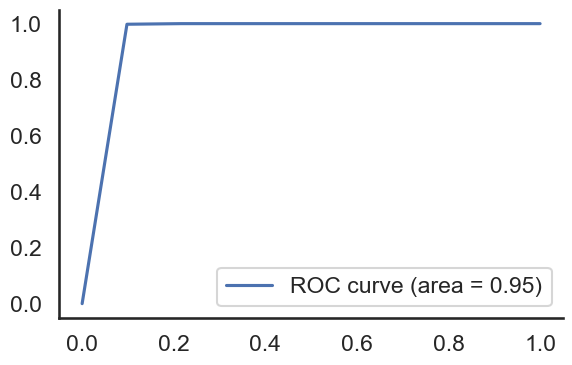

In [382]:
y_pred_prob = neigh.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, label='ROC curve (area = %0.2f)' % roc_auc)
sns.despine();

In [383]:
classifier_input["knn"] = neigh.predict(X)
classifier_input

,ProteinWindowSeq,GeneName,Start,End,A,C,D,E,F,G,...,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr,uniprotID,AD_suffic_overlap,knn,log_reg
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,2,0,3,5,1,4,...,0,0,0.200000,0.050000,0.65000,-0.150000,A0A087WUV0,False,False,True
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,2,0,3,2,0,2,...,1,0,0.125000,0.100000,0.62500,-0.025000,A0A087WUV0,False,False,True
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,2,0,1,12,0,0,...,1,0,0.325000,0.125000,0.82500,-0.200000,A0A087WUV0,False,False,False
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,2,1,1,8,1,1,...,0,0,0.225000,0.075000,0.72500,-0.150000,A0A087WUV0,False,False,False
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,2,4,2,1,...,0,1,0.150000,0.200000,0.72500,0.050000,A0A087WUV0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,5,0,2,7,3,0,...,1,0,0.225000,0.050000,0.70000,-0.175000,Q9Y6Y1,False,True,True
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,6,1,0,4,1,1,...,0,3,0.100000,0.250000,0.70000,0.150000,Q9Y6Y1,False,False,False
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,5,0,0,1,2,0,...,0,5,0.025000,0.225000,0.62500,0.200000,Q9Y6Y1,False,False,False
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,4,1,1,0,0,1,...,0,3,0.025000,0.325000,0.75000,0.300000,Q9Y6Y1,False,False,False


# 2. Logistic Regression

In [403]:
# import the class
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8779386155855463


In [404]:
f1 = f1_score(y_test, y_pred)
print(f'F1: {f1}')

F1: 0.8802136181575434


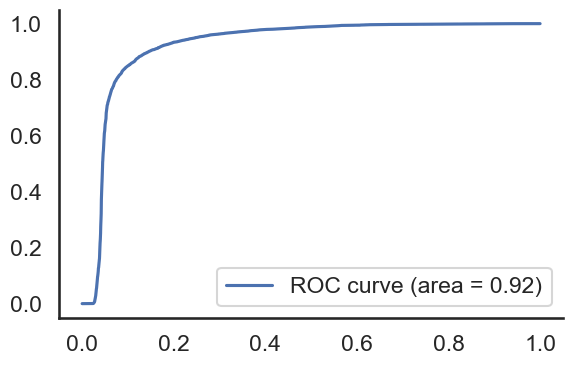

In [405]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, label='ROC curve (area = %0.2f)' % roc_auc)
sns.despine();

In [387]:
classifier_input["log_reg"] = logreg.predict(X)
classifier_input

,ProteinWindowSeq,GeneName,Start,End,A,C,D,E,F,G,...,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr,uniprotID,AD_suffic_overlap,knn,log_reg
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,2,0,3,5,1,4,...,0,0,0.200000,0.050000,0.65000,-0.150000,A0A087WUV0,False,False,False
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,2,0,3,2,0,2,...,1,0,0.125000,0.100000,0.62500,-0.025000,A0A087WUV0,False,False,False
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,2,0,1,12,0,0,...,1,0,0.325000,0.125000,0.82500,-0.200000,A0A087WUV0,False,False,False
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,2,1,1,8,1,1,...,0,0,0.225000,0.075000,0.72500,-0.150000,A0A087WUV0,False,False,False
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,2,4,2,1,...,0,1,0.150000,0.200000,0.72500,0.050000,A0A087WUV0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,5,0,2,7,3,0,...,1,0,0.225000,0.050000,0.70000,-0.175000,Q9Y6Y1,False,True,False
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,6,1,0,4,1,1,...,0,3,0.100000,0.250000,0.70000,0.150000,Q9Y6Y1,False,False,False
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,5,0,0,1,2,0,...,0,5,0.025000,0.225000,0.62500,0.200000,Q9Y6Y1,False,False,False
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,4,1,1,0,0,1,...,0,3,0.025000,0.325000,0.75000,0.300000,Q9Y6Y1,False,False,False


# 3. Decision Tree

In [388]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.914235959947758


In [389]:
pd.DataFrame({"feature" : X_train.columns, "importance" : clf.feature_importances_}).sort_values(by = "importance", ascending = False)

,feature,importance
21,frac_pos,0.533185
6,H,0.044052
22,frac_disord_prom,0.040544
15,S,0.027661
20,frac_neg,0.026684
23,ncpr,0.026000
14,R,0.024321
17,V,0.021947
13,Q,0.021913
12,P,0.019942


In [390]:
# fig = plt.figure(figsize=(20,4), dpi = 300)
# _ = tree.plot_tree(clf, 
#                    filled=True,
#                    feature_names=X_train.columns,
#                   class_names = ["Not AD", "AD"], impurity = False)

In [391]:
dt_clf_preds = clf.predict(X)
classifier_input["decision_tree"] = dt_clf_preds
classifier_input

,ProteinWindowSeq,GeneName,Start,End,A,C,D,E,F,G,...,Y,frac_neg,frac_pos,frac_disord_prom,ncpr,uniprotID,AD_suffic_overlap,knn,log_reg,decision_tree
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,2,0,3,5,1,4,...,0,0.200000,0.050000,0.65000,-0.150000,A0A087WUV0,False,False,False,False
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,2,0,3,2,0,2,...,0,0.125000,0.100000,0.62500,-0.025000,A0A087WUV0,False,False,False,False
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,2,0,1,12,0,0,...,0,0.325000,0.125000,0.82500,-0.200000,A0A087WUV0,False,False,False,False
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,2,1,1,8,1,1,...,0,0.225000,0.075000,0.72500,-0.150000,A0A087WUV0,False,False,False,False
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,2,4,2,1,...,1,0.150000,0.200000,0.72500,0.050000,A0A087WUV0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,5,0,2,7,3,0,...,0,0.225000,0.050000,0.70000,-0.175000,Q9Y6Y1,False,True,False,False
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,6,1,0,4,1,1,...,3,0.100000,0.250000,0.70000,0.150000,Q9Y6Y1,False,False,False,False
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,5,0,0,1,2,0,...,5,0.025000,0.225000,0.62500,0.200000,Q9Y6Y1,False,False,False,False
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,4,1,1,0,0,1,...,3,0.025000,0.325000,0.75000,0.300000,Q9Y6Y1,False,False,False,False


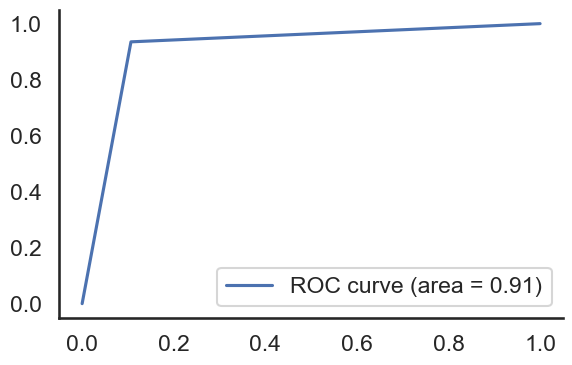

In [392]:
y_pred_prob = clf.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, label='ROC curve (area = %0.2f)' % roc_auc)
sns.despine();

# 4. Random forest

In [393]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.962070091423596


In [394]:
f1 = f1_score(y_test, y_pred)
print(f'F1: {f1}')

F1: 0.9622529109125373


In [395]:
precision_score(y_test, y_pred)

0.9601210418242732

In [396]:
recall_score(y_test, y_pred)

0.9643942683456361

In [397]:
pd.DataFrame({"feature" : X_train.columns, 
              "importance" : rf_clf.feature_importances_}).sort_values(by = "importance", 
                                                                       ascending = False)

,feature,importance
21,frac_pos,0.153541
8,K,0.104610
23,ncpr,0.099583
22,frac_disord_prom,0.054664
1,C,0.054213
20,frac_neg,0.051005
14,R,0.050667
6,H,0.038723
12,P,0.034767
3,E,0.034149


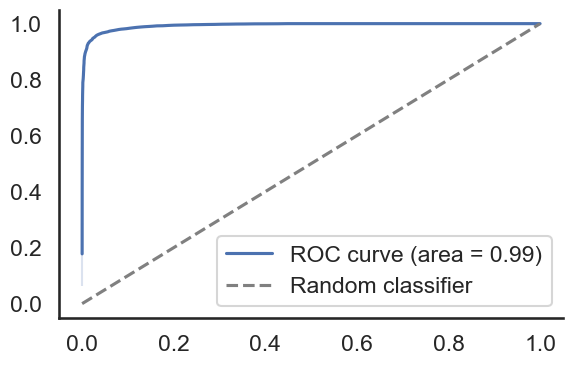

In [398]:
y_pred_prob = rf_clf.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', label='Random classifier', color = 'gray') 
plt.legend()
sns.despine();

In [399]:
rc_clf_preds = rf_clf.predict(X)
classifier_input["random_forest"] = rc_clf_preds
classifier_input

,ProteinWindowSeq,GeneName,Start,End,A,C,D,E,F,G,...,frac_neg,frac_pos,frac_disord_prom,ncpr,uniprotID,AD_suffic_overlap,knn,log_reg,decision_tree,random_forest
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,2,0,3,5,1,4,...,0.200000,0.050000,0.65000,-0.150000,A0A087WUV0,False,False,False,False,False
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,2,0,3,2,0,2,...,0.125000,0.100000,0.62500,-0.025000,A0A087WUV0,False,False,False,False,False
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,2,0,1,12,0,0,...,0.325000,0.125000,0.82500,-0.200000,A0A087WUV0,False,False,False,False,False
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,2,1,1,8,1,1,...,0.225000,0.075000,0.72500,-0.150000,A0A087WUV0,False,False,False,False,False
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,2,4,2,1,...,0.150000,0.200000,0.72500,0.050000,A0A087WUV0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,5,0,2,7,3,0,...,0.225000,0.050000,0.70000,-0.175000,Q9Y6Y1,False,True,False,False,False
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,6,1,0,4,1,1,...,0.100000,0.250000,0.70000,0.150000,Q9Y6Y1,False,False,False,False,False
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,5,0,0,1,2,0,...,0.025000,0.225000,0.62500,0.200000,Q9Y6Y1,False,False,False,False,False
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,4,1,1,0,0,1,...,0.025000,0.325000,0.75000,0.300000,Q9Y6Y1,False,False,False,False,False


In [400]:
# # Trying with less features
# features = ['K', 'C', 'frac_neg', 'frac_pos',
#        'frac_disord_prom', 'ncpr']
# len(features)

# 5. Evaluating performance on parts of input data which were not in training

In [401]:
training_classifier_input = pd.merge(classifier_input, X_train)
test_classifier_input = classifier_input[~classifier_input["ProteinWindowSeq"].isin(training_classifier_input["ProteinWindowSeq"])]
test_classifier_input

,ProteinWindowSeq,GeneName,Start,End,A,C,D,E,F,G,...,frac_neg,frac_pos,frac_disord_prom,ncpr,uniprotID,AD_suffic_overlap,knn,log_reg,decision_tree,random_forest
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,2,0,3,5,1,4,...,0.200000,0.050000,0.65000,-0.150000,A0A087WUV0,False,False,False,False,False
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,2,0,3,2,0,2,...,0.125000,0.100000,0.62500,-0.025000,A0A087WUV0,False,False,False,False,False
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,2,4,2,1,...,0.150000,0.200000,0.72500,0.050000,A0A087WUV0,False,False,False,False,False
6,RIHTGEKPYECNECGKAFSQSIHLTLHQRIHTGEKPYECH,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,240,280,1,3,0,5,1,3,...,0.125000,0.125000,0.70000,0.000000,A0A087WUV0,False,False,False,False,False
7,ECGKAFSHRSALIRHHIIHTGEKPYECNECGKAFNQSSYL,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,280,320,3,3,0,4,2,3,...,0.100000,0.125000,0.65000,0.025000,A0A087WUV0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24526,GHLEAAVVLYKWDRRAISIPDSLGRLPLGIARSRGHVKLA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1120,1160,5,0,2,1,0,4,...,0.075000,0.175000,0.65000,0.100000,Q9Y6Y1,False,False,False,False,False
24529,PAPKKHKLNPEYFQTRQEKLLPTALSLEEPNIRKQSPSSK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1240,1280,2,0,0,4,1,0,...,0.100000,0.200000,0.75000,0.100000,Q9Y6Y1,False,False,False,False,False
24531,WNSKDLYIGVSTVQVTGNPKGTSVGKEAAPSQVRPREPMS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1320,1360,2,0,1,2,0,4,...,0.075000,0.125000,0.70000,0.050000,Q9Y6Y1,False,False,False,False,False
24534,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1440,1480,6,1,2,1,0,1,...,0.075000,0.025000,0.70000,-0.050000,Q9Y6Y1,False,True,True,False,False


In [331]:
def eval_test(model_name):
    print("Accuracy:")
    print(accuracy_score(test_classifier_input["AD_suffic_overlap"], test_classifier_input[model_name]))

    print("F1:")
    print(f1_score(test_classifier_input["AD_suffic_overlap"], test_classifier_input[model_name]))

    print("\nMistake types:")
    display(test_classifier_input[test_classifier_input["AD_suffic_overlap"] != test_classifier_input[model_name]][["AD_suffic_overlap", model_name]].value_counts())
    

In [332]:
eval_test("knn")

Accuracy:
0.8186517783291977
F1:
0.4226464779460171

Mistake types:


AD_suffic_overlap  knn 
False              True    877
Name: count, dtype: int64

In [377]:
eval_test("log_reg")

Accuracy:
0.7080336963221697
F1:
0.2656330749354005

Mistake types:


AD_suffic_overlap  log_reg
False              True       1357
True               False        64
Name: count, dtype: int64

In [334]:
eval_test("decision_tree")

Accuracy:
0.8631100082712986
F1:
0.298728813559322

Mistake types:


AD_suffic_overlap  decision_tree
False              True             482
True               False            180
Name: count, dtype: int64

In [335]:
eval_test("random_forest")

Accuracy:
0.9416873449131513
F1:
0.5566037735849056

Mistake types:


AD_suffic_overlap  random_forest
True               False            144
False              True             138
Name: count, dtype: int64

In [336]:
test_classifier_input

,ProteinWindowSeq,GeneName,Start,End,A,C,D,E,F,G,...,frac_neg,frac_pos,frac_disord_prom,ncpr,uniprotID,AD_suffic_overlap,random_forest,knn,log_reg,decision_tree
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,2,0,3,2,0,2,...,0.125,0.100,0.625,-0.025,A0A087WUV0,False,False,False,False,False
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,2,4,2,1,...,0.150,0.200,0.725,0.050,A0A087WUV0,False,False,False,False,False
7,ECGKAFSHRSALIRHHIIHTGEKPYECNECGKAFNQSSYL,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,280,320,3,3,0,4,2,3,...,0.100,0.125,0.650,0.025,A0A087WUV0,False,False,False,False,False
11,GEKPYKCKDCGKAFSQSSSLTKHQKTHTGEKPYKCKECGK,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,440,480,1,4,1,3,1,4,...,0.100,0.250,0.800,0.150,A0A087WUV0,False,False,False,False,False
13,TG,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,520,522,0,0,0,0,0,1,...,0.000,0.000,1.000,0.000,A0A087WUV0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24517,SLDHFDISFSNQFSDLINDFISVEGGSSTIYGHQLVSGDS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,760,800,0,0,5,1,4,4,...,0.150,0.000,0.600,-0.150,Q9Y6Y1,True,True,True,True,True
24521,LRCYCPAHDTGLVTLQVAFNNQIISNSVVFEYKARALPTL,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,920,960,4,2,1,1,2,1,...,0.050,0.075,0.500,0.025,Q9Y6Y1,False,False,True,False,False
24525,IQTLIKWRTKHADSIDLELEVDPLNVDHFSCTPLMWACAL,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1080,1120,3,2,4,2,1,0,...,0.150,0.075,0.550,-0.075,Q9Y6Y1,False,False,True,False,False
24529,PAPKKHKLNPEYFQTRQEKLLPTALSLEEPNIRKQSPSSK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1240,1280,2,0,0,4,1,0,...,0.100,0.200,0.750,0.100,Q9Y6Y1,False,False,False,False,False


In [337]:
def plot_roc(model, model_name, test_classifier_input = test_classifier_input):
    y_pred_prob = model.predict_proba(test_classifier_input[features])[:, 1] 
    fpr, tpr, thresholds = roc_curve(test_classifier_input["AD_suffic_overlap"], y_pred_prob, pos_label=1)
    roc_auc = roc_auc_score(test_classifier_input["AD_suffic_overlap"], y_pred_prob) 
    sns.set_context('talk')
    sns.lineplot(x = fpr, y = tpr, label= model_name + '\n(AUROC = %0.2f)' % roc_auc)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    #plt.text(x = 1, y = 0.05, s = 'AUROC = %0.2f' % roc_auc, ha = "right", color = "b")

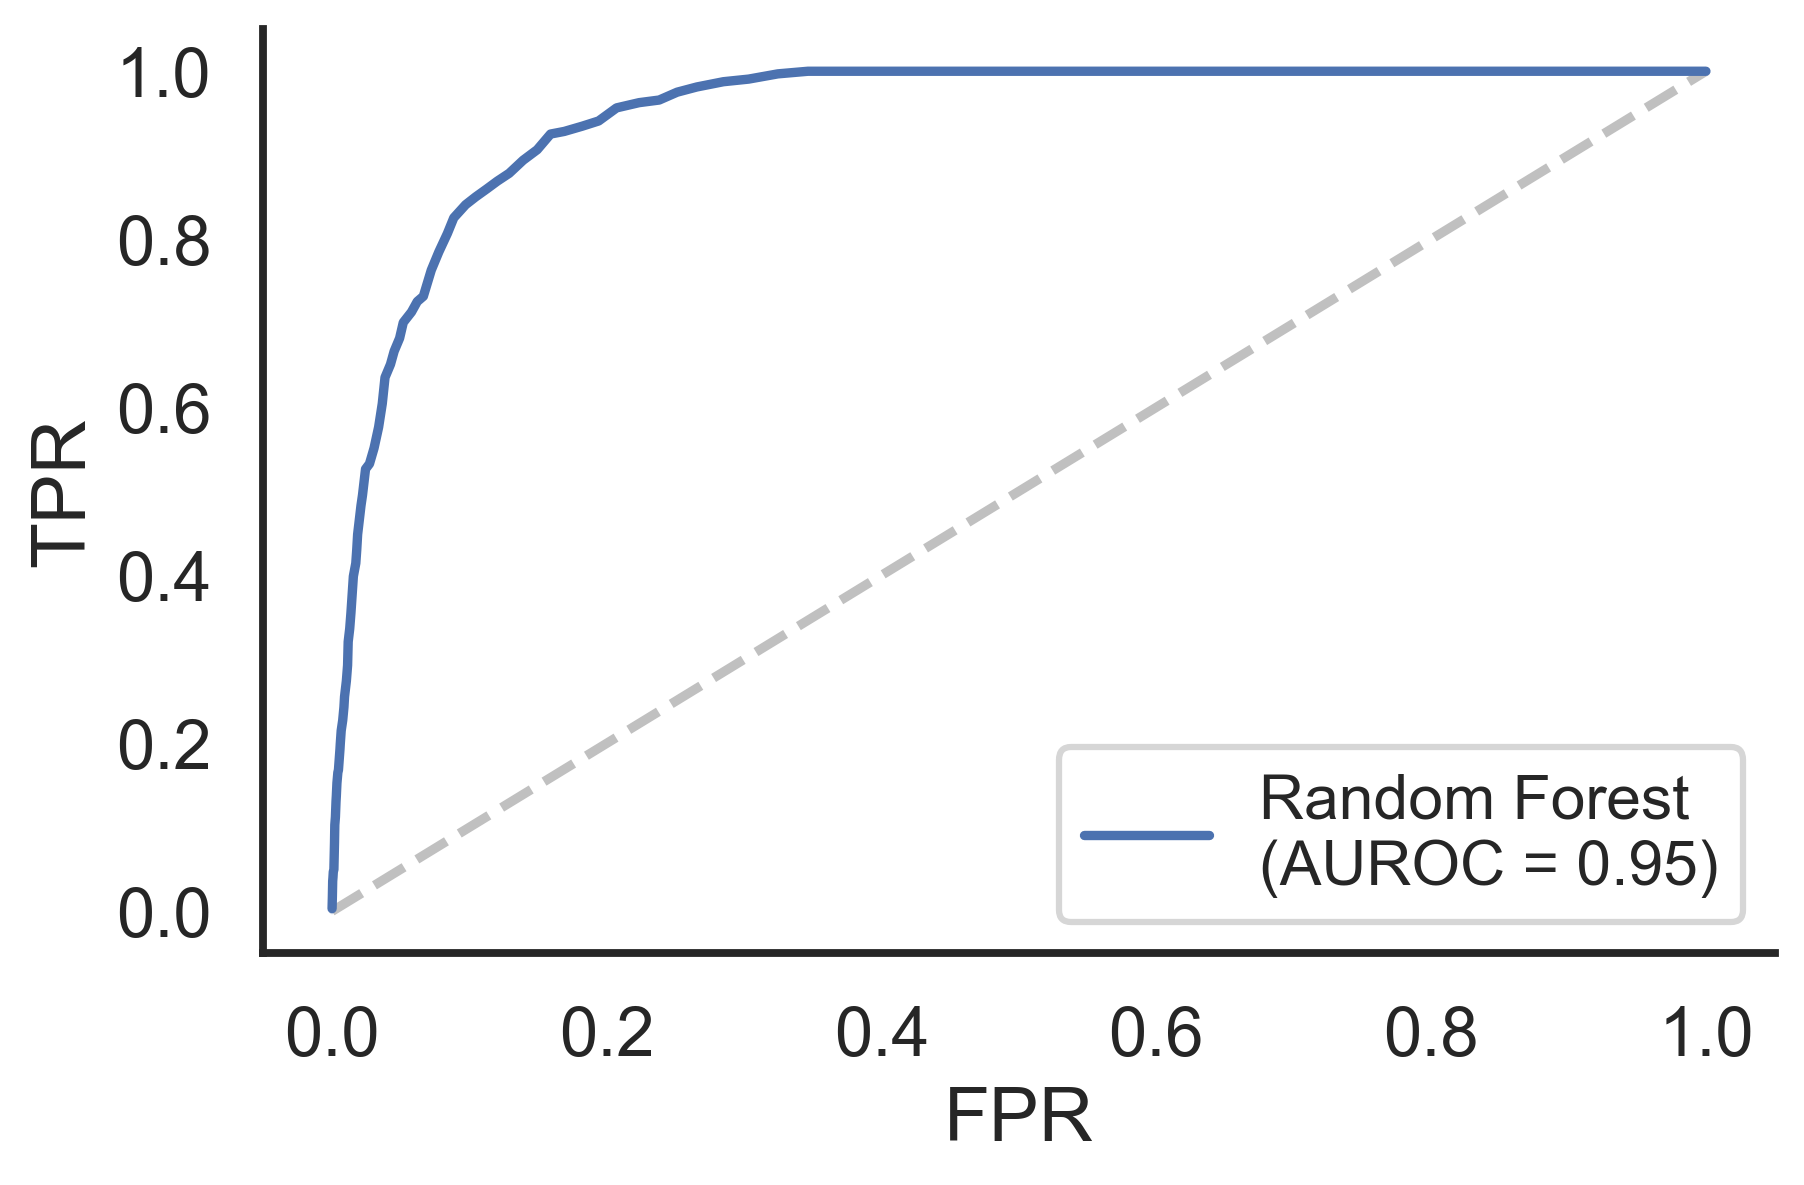

In [338]:
sns.set_context('talk')
plt.figure(dpi = 300)
sns.set_style('white')
plt.plot([0, 1], [0, 1], '--', color = "silver") 
#plot_roc(neigh, "KNN, n = 3")
plot_roc(rf_clf, "Random Forest")
#plot_roc(clf, "Decision Tree")
#plot_roc(logreg, "Logistic Regression")
plt.legend(fontsize = "small")
sns.despine();

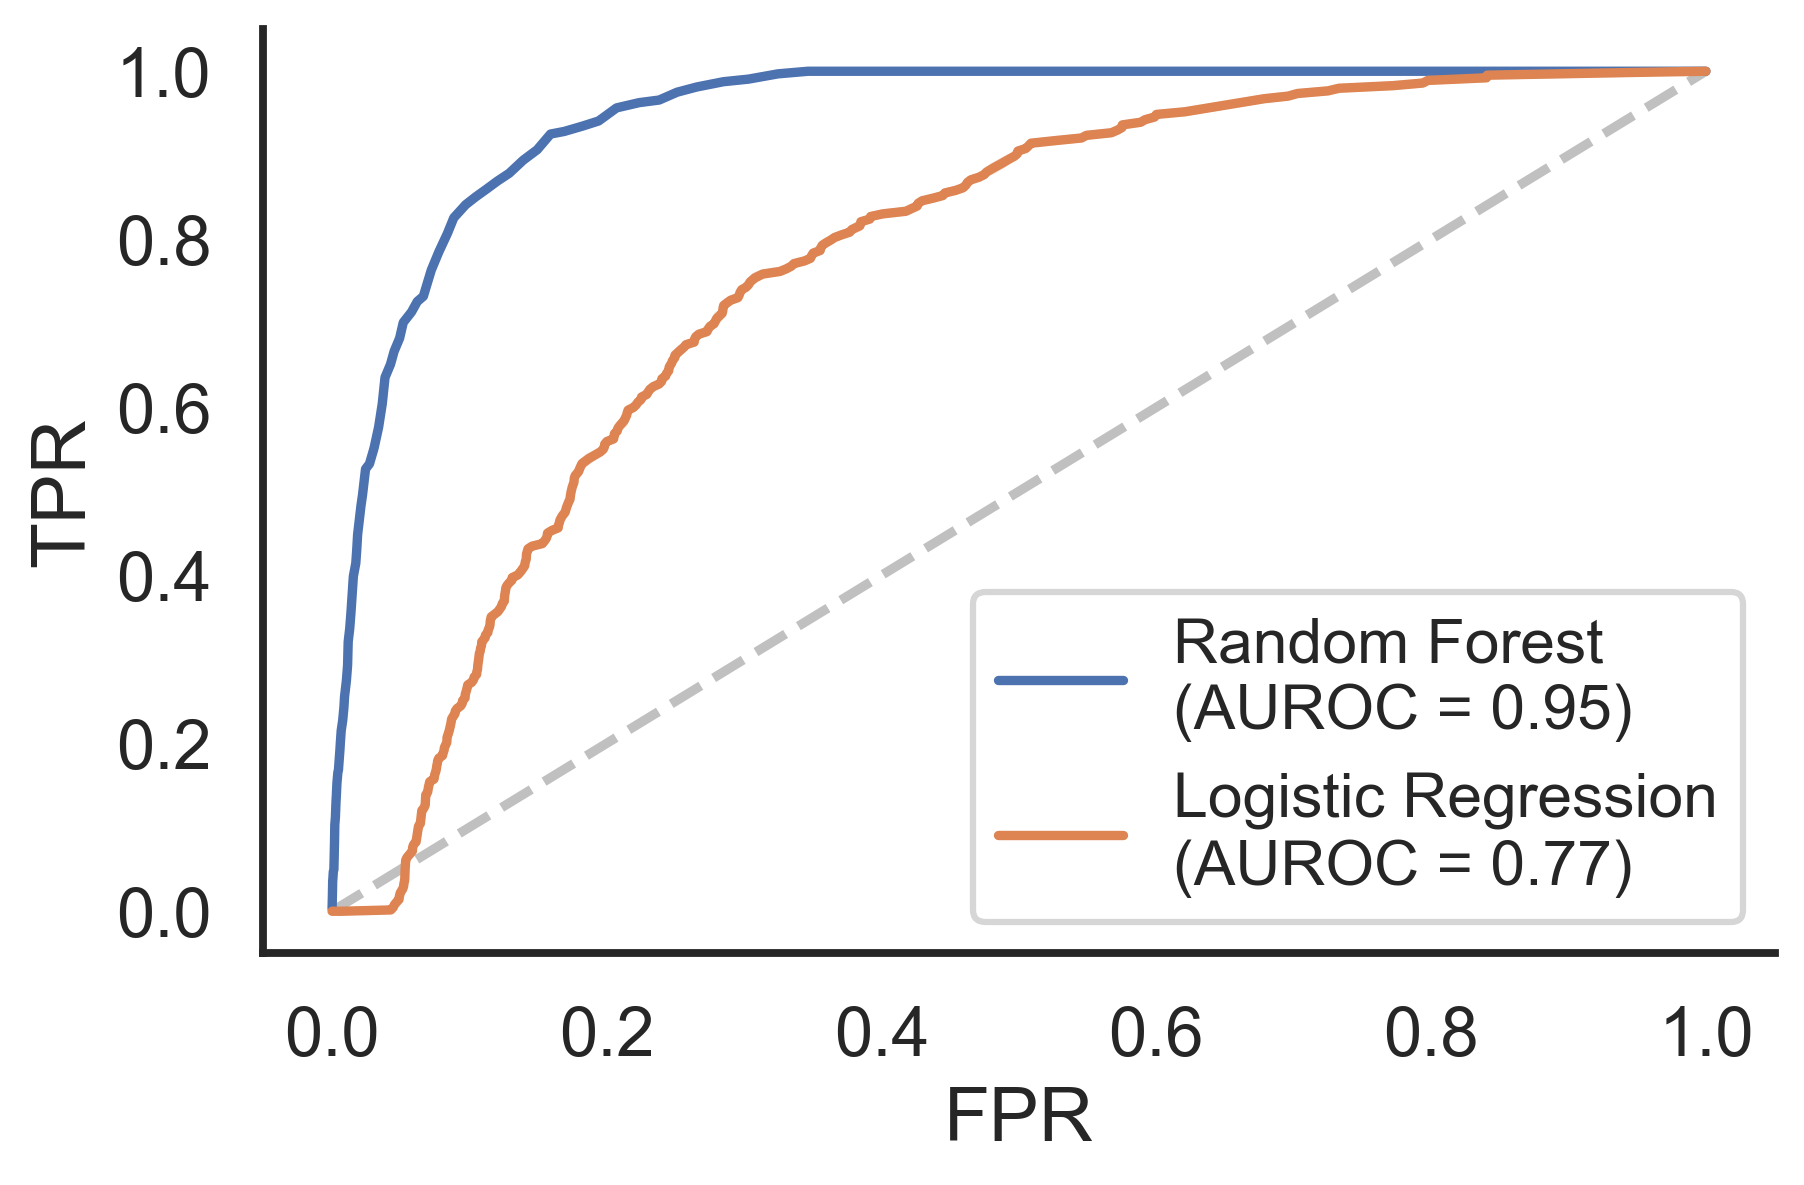

In [339]:
sns.set_context('talk')
plt.figure(dpi = 300)
sns.set_style('white')
plt.plot([0, 1], [0, 1], '--', color = "silver") 
plot_roc(rf_clf, "Random Forest")
#plot_roc(neigh, "KNN, n = 3")
#plot_roc(clf, "Decision Tree")
plot_roc(logreg, "Logistic Regression")
plt.legend(fontsize = "small")
sns.despine();

# 6. How well does the random forest generalize to sequences never seen before?

In [340]:
padi = pd.read_excel("../data/padi_data.xlsx")
padi

,Sub Library,Fragment Name,Fragment Sequence,Gene Model,ATG Number,Start Position,PADI Score,TF Family,Mean Disorder,AD Subtype,...,CountN,CountP,CountQ,CountR,CountS,CountT,CountV,CountW,CountY,Aromatics
0,Lib1,AT1G01010.1_1,MEDQVGFGFRPNDEELVGHYLRNKIEGNTSRDVEVAISEV,AT1G01010.1,AT1G01010,1,1.004699,NAC,0.254442,1.0,...,3,1,1,3,2,1,5,0,1,5
1,Lib1,AT1G01010.1_11,PNDEELVGHYLRNKIEGNTSRDVEVAISEVNICSYDPWNL,AT1G01010.1,AT1G01010,11,0.575876,NAC,0.131235,NaN,...,5,2,0,2,3,1,4,1,2,6
2,Lib1,AT1G01010.1_21,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,AT1G01010.1,AT1G01010,21,-0.300407,NAC,0.104265,NaN,...,4,1,1,4,5,1,3,1,2,6
3,Lib1,AT1G01010.1_31,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,AT1G01010.1,AT1G01010,31,0.105372,NAC,0.105342,NaN,...,2,1,1,5,5,0,3,2,3,9
4,Lib1,AT1G01010.1_41,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,AT1G01010.1,AT1G01010,41,-0.167147,NAC,0.240860,NaN,...,5,1,2,6,5,1,0,2,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69568,Lib10,ATMG00940.1_91,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,ATMG00940.1,ATMG00940,91,-0.139281,Other,0.084480,NaN,...,0,1,1,2,4,4,4,2,0,5
69569,Lib10,ATMG00940.1_101,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,ATMG00940.1,ATMG00940,101,-0.064551,Other,0.104625,NaN,...,0,1,2,2,3,6,2,2,2,7
69570,Lib10,ATMG00940.1_111,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,ATMG00940.1,ATMG00940,111,-0.410777,Other,0.159452,NaN,...,1,2,2,3,4,5,2,3,2,7
69571,Lib10,ATMG00940.1_121,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,ATMG00940.1,ATMG00940,121,0.329820,Other,0.204375,NaN,...,1,4,2,3,4,4,1,3,3,10


In [341]:
padi["active"] = padi["PADI Score"] > 1
padi = padi[["Fragment Sequence", "active"]]
padi = padi.rename(columns = {"Fragment Sequence" : "ProteinWindowSeq"})
padi

,ProteinWindowSeq,active
0,MEDQVGFGFRPNDEELVGHYLRNKIEGNTSRDVEVAISEV,True
1,PNDEELVGHYLRNKIEGNTSRDVEVAISEVNICSYDPWNL,False
2,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,False
3,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,False
4,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,False
...,...,...
69568,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,False
69569,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,False
69570,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,False
69571,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,False


In [342]:
# AA counts
def prep_df(classifier_input):
    AAs = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

    for AA in AAs:
        classifier_input[AA] = classifier_input["ProteinWindowSeq"].str.count(AA)
    
    classifier_input["frac_neg"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_fraction_negative())
    classifier_input["frac_pos"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_fraction_positive())
    classifier_input["frac_disord_prom"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_fraction_disorder_promoting())
    classifier_input["ncpr"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_NCPR(pH = None))

In [343]:
prep_df(padi)
padi

,ProteinWindowSeq,active,A,C,D,E,F,G,H,I,...,R,S,T,V,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr
0,MEDQVGFGFRPNDEELVGHYLRNKIEGNTSRDVEVAISEV,True,1,0,3,6,2,4,1,2,...,3,2,1,5,0,1,0.225,0.100,0.600,-0.125
1,PNDEELVGHYLRNKIEGNTSRDVEVAISEVNICSYDPWNL,False,1,1,3,5,0,2,1,3,...,2,3,1,4,1,2,0.200,0.075,0.525,-0.125
2,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,False,1,1,3,3,1,1,0,3,...,4,5,1,3,1,2,0.150,0.175,0.575,0.025
3,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,False,2,1,3,3,3,0,0,2,...,5,5,0,3,2,3,0.150,0.175,0.550,0.025
4,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,False,1,1,2,1,3,1,0,1,...,6,5,1,0,2,3,0.075,0.225,0.575,0.150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69568,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,False,4,0,3,4,3,1,0,2,...,2,4,4,4,2,0,0.175,0.100,0.650,-0.075
69569,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,False,3,0,1,4,3,2,0,3,...,2,3,6,2,2,2,0.125,0.075,0.625,-0.050
69570,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,False,1,0,1,3,2,4,0,2,...,3,4,5,2,3,2,0.100,0.100,0.650,0.000
69571,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,False,0,0,1,2,4,3,0,4,...,3,4,4,1,3,3,0.075,0.100,0.600,0.025


In [344]:
padi_input = padi[features]
padi_input

,A,C,D,E,F,G,H,I,K,L,...,R,S,T,V,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr
0,1,0,3,6,2,4,1,2,1,2,...,3,2,1,5,0,1,0.225,0.100,0.600,-0.125
1,1,1,3,5,0,2,1,3,1,3,...,2,3,1,4,1,2,0.200,0.075,0.525,-0.125
2,1,1,3,3,1,1,0,3,3,2,...,4,5,1,3,1,2,0.150,0.175,0.575,0.025
3,2,1,3,3,3,0,0,2,2,1,...,5,5,0,3,2,3,0.150,0.175,0.550,0.025
4,1,1,2,1,3,1,0,1,3,1,...,6,5,1,0,2,3,0.075,0.225,0.575,0.150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69568,4,0,3,4,3,1,0,2,2,0,...,2,4,4,4,2,0,0.175,0.100,0.650,-0.075
69569,3,0,1,4,3,2,0,3,1,0,...,2,3,6,2,2,2,0.125,0.075,0.625,-0.050
69570,1,0,1,3,2,4,0,2,1,0,...,3,4,5,2,3,2,0.100,0.100,0.650,0.000
69571,0,0,1,2,4,3,0,4,1,0,...,3,4,4,1,3,3,0.075,0.100,0.600,0.025


In [378]:
padi["random_forest"] = rf_clf.predict(padi_input)
padi["decision_tree"] = clf.predict(padi_input)
padi["knn"] = neigh.predict(padi_input)
padi["logreg"] = logreg.predict(padi_input)
padi

,ProteinWindowSeq,active,A,C,D,E,F,G,H,I,...,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr,random_forest,decision_tree,knn,logreg
0,MEDQVGFGFRPNDEELVGHYLRNKIEGNTSRDVEVAISEV,True,1,0,3,6,2,4,1,2,...,0,1,0.225,0.100,0.600,-0.125,False,False,False,True
1,PNDEELVGHYLRNKIEGNTSRDVEVAISEVNICSYDPWNL,False,1,1,3,5,0,2,1,3,...,1,2,0.200,0.075,0.525,-0.125,False,False,False,True
2,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,False,1,1,3,3,1,1,0,3,...,1,2,0.150,0.175,0.575,0.025,False,True,False,False
3,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,False,2,1,3,3,3,0,0,2,...,2,3,0.150,0.175,0.550,0.025,False,True,False,False
4,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,False,1,1,2,1,3,1,0,1,...,2,3,0.075,0.225,0.575,0.150,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69568,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,False,4,0,3,4,3,1,0,2,...,2,0,0.175,0.100,0.650,-0.075,False,False,False,True
69569,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,False,3,0,1,4,3,2,0,3,...,2,2,0.125,0.075,0.625,-0.050,False,True,True,True
69570,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,False,1,0,1,3,2,4,0,2,...,3,2,0.100,0.100,0.650,0.000,False,False,False,True
69571,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,False,0,0,1,2,4,3,0,4,...,3,3,0.075,0.100,0.600,0.025,False,False,False,True


In [346]:
padi["active"].value_counts()

active
False    63366
True      6207
Name: count, dtype: int64

In [402]:
for model in ["random_forest", "decision_tree", "knn", "logreg"]:
    print(model)
    print("Accuracy: " + str(np.round(accuracy_score(padi["active"], padi[model]), 3)))
    print("F1: " + str(np.round(f1_score(padi["active"], padi[model]), 3)))
    print(sum(padi[model]))
    print()

random_forest
Accuracy: 0.902
F1: 0.25
2886

decision_tree
Accuracy: 0.826
F1: 0.203
8970

knn
Accuracy: 0.898
F1: 0.13
1947

logreg
Accuracy: 0.638
F1: 0.277
28588



In [296]:
padi[~padi["active"] & padi["random_forest"]]

,ProteinWindowSeq,active,A,C,D,E,F,G,H,I,...,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr,random_forest,decision_tree,knn,logreg
19,QRNSGSYNTYSEYDSANHGQQFNENSNIMQQQPLQGSFNP,False,1,0,1,2,2,3,1,1,...,0,3,0.075,0.025,0.625,-0.050,True,True,False,True
20,SEYDSANHGQQFNENSNIMQQQPLQGSFNPLLEYDFANHG,False,2,0,2,3,3,3,2,1,...,0,2,0.125,0.000,0.600,-0.125,True,False,True,True
40,MDLSLAPTTTTSSDQEQDRDQELTSNIGASSSSGPSGNNN,False,2,0,4,2,0,3,0,1,...,0,0,0.150,0.025,0.775,-0.125,True,True,True,True
41,TSSDQEQDRDQELTSNIGASSSSGPSGNNNNLPMMMIPPP,False,1,0,3,2,0,3,0,2,...,0,0,0.125,0.025,0.700,-0.100,True,True,False,True
69,MECGNDYNQQEESWLVPRGEIGASSSSSSALRLNLSTDHD,False,2,1,3,4,0,3,1,1,...,1,1,0.175,0.050,0.675,-0.125,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69422,PSVELFKPVPRPGAVVLPLPIETSSSSDDPPTSLSLSLPG,False,1,0,2,2,1,2,0,1,...,0,0,0.100,0.050,0.700,-0.050,True,False,True,True
69423,RPGAVVLPLPIETSSSSDDPPTSLSLSLPGADVSEESNRS,False,2,0,3,3,0,2,0,1,...,0,0,0.150,0.050,0.750,-0.100,True,False,True,True
69424,IETSSSSDDPPTSLSLSLPGADVSEESNRSHESTNINNTT,False,1,0,3,4,0,1,1,2,...,0,0,0.175,0.025,0.750,-0.150,True,True,True,True
69444,HYIPDEILTSNLRSVFLKELRDLNPTIVTLIDEDSDFTST,False,0,0,5,3,2,0,1,4,...,0,1,0.200,0.075,0.575,-0.125,True,False,False,False
